<a href="https://colab.research.google.com/github/zeev-haydar/ML-TuneHive/blob/model-development%2Fhaidar/model-dev/preprocessing-modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Dec 11 14:15:14 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Preprocessing and Modeling

## Import required modules

In [2]:
import tensorflow as tf

from sklearn.model_selection import train_test_split

import tensorflow_datasets as tfds

from keras.api.layers import Dense, Embedding, GRU, LeakyReLU, Concatenate, Masking, Layer, StringLookup, Normalization, BatchNormalization, Attention, Dropout

from keras.api import Input

from keras.api.models import Model

from keras.api.losses import SparseCategoricalCrossentropy

from keras.api.metrics import SparseCategoricalAccuracy, Mean, TopKCategoricalAccuracy

# from transformers.models.bert import TFBertTokenizer, TFBertEmbeddings  # embedding and tokenizer for description/nlp related stufff

from keras.api.optimizers import Adam

import matplotlib.pyplot as plt

import pandas as pd

import numpy as np

import ast

## Preprocessing

### Load CSV

In [3]:
# For Running in Google Colab

# "https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{file}"

url = "https://raw.githubusercontent.com/zeev-haydar/ML-TuneHive/main/model-dev/data/session-data.csv"

!wget --no-cache --backups=1 {url}

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-12-11 14:15:32--  https://raw.githubusercontent.com/zeev-haydar/ML-TuneHive/main/model-dev/data/session-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21952709 (21M) [text/plain]
Failed to rename session-data.csv to session-data.csv.1: (2) No such file or directory
Saving to: 'session-data.csv'

session-data.csv    100%[===================>]  20.94M  --.-KB/s    in 0.06s   

2024-12-11 14:15:33 (332 MB/s) - 'session-data.csv' saved [21952709/21952709]



In [4]:
import keras

import os

print(keras.__version__)



# root_path = "data"

root_path = "" # if using colab

df = pd.read_csv(os.path.join(root_path, "session-data.csv"))

df

3.3.3


,index_x,SongID,TimeStamp_Central,Performer_x,Album,Song_x,TimeStamp_UTC,index_y,Performer_y,Song_y,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,session_3_hour,session_id
0,0,Twenty Five MilesEdwin Starr,5/25/2021 5:18:00 PM,Edwin Starr,25 Miles,Twenty Five Miles,2021-05-25 23:18:00,9761,Edwin Starr,Twenty Five Miles,...,1.0,0.0607,0.0595,0.000015,0.2240,0.964,124.567,4.0,2021-05-25 21:00:00,4332
1,1,Devil's EyesGreyhounds,5/25/2021 5:15:00 PM,Greyhounds,Change of Pace,Devil's Eyes,2021-05-25 23:15:00,206,Greyhounds,Devil's Eyes,...,0.0,0.0456,0.3540,0.000414,0.0974,0.858,113.236,4.0,2021-05-25 21:00:00,4332
2,2,Pussy and PizzaMurs,5/25/2021 5:12:00 PM,Murs,Have a Nice Life,Pussy and Pizza,2021-05-25 23:12:00,6404,Murs,Pussy and Pizza,...,1.0,0.0659,0.0708,0.000004,0.0780,0.381,93.991,4.0,2021-05-25 21:00:00,4332
3,8,Our Special PlaceThe Heavy,5/25/2021 4:46:00 PM,The Heavy,Great Vengeance and Furious Fire,Our Special Place,2021-05-25 22:46:00,6205,The Heavy,Our Special Place,...,1.0,0.0386,0.2720,0.003610,0.0991,0.939,193.996,4.0,2021-05-25 21:00:00,4332
4,10,Make Peace and be FreePerfect Confusion,5/25/2021 4:39:00 PM,Perfect Confusion,Perfect Confusion,Make Peace and be Free,2021-05-25 22:39:00,6051,Perfect Confusion,Make Peace and be Free,...,1.0,0.0315,0.0138,0.000017,0.0649,0.431,78.037,4.0,2021-05-25 21:00:00,4332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50013,62902,From Me To You - Remastered 2009The Beatles,1/1/2017 10:04:00 AM,The Beatles,Past Masters (Vols. 1 & 2 / Remastered),From Me To You - Remastered 2009,2017-01-01 16:04:00,5693,The Beatles,From Me To You - Remastered 2009,...,1.0,0.0309,0.6130,0.000000,0.2690,0.966,136.125,4.0,2017-01-01 15:00:00,0
50014,62903,And I Love Her - Remastered 2009The Beatles,1/1/2017 10:01:00 AM,The Beatles,A Hard Day's Night (Remastered),And I Love Her - Remastered 2009,2017-01-01 16:01:00,360,The Beatles,And I Love Her - Remastered 2009,...,0.0,0.0337,0.6400,0.000000,0.0681,0.636,113.312,4.0,2017-01-01 15:00:00,0
50015,62904,Ticket To Ride - Remastered 2009The Beatles,1/1/2017 9:58:00 AM,The Beatles,Help! (Remastered),Ticket To Ride - Remastered 2009,2017-01-01 15:58:00,9715,The Beatles,Ticket To Ride - Remastered 2009,...,1.0,0.0678,0.0457,0.000000,0.2330,0.749,123.419,4.0,2017-01-01 15:00:00,0
50016,62905,Come Together - Remastered 2009The Beatles,1/1/2017 9:54:00 AM,The Beatles,Abbey Road (Remastered),Come Together - Remastered 2009,2017-01-01 15:54:00,7425,The Beatles,Come Together - Remastered 2009,...,0.0,0.0393,0.0302,0.248000,0.0926,0.187,165.007,4.0,2017-01-01 15:00:00,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50018 entries, 0 to 50017
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index_x                    50018 non-null  int64  
 1   SongID                     50018 non-null  object 
 2   TimeStamp_Central          50018 non-null  object 
 3   Performer_x                50018 non-null  object 
 4   Album                      47890 non-null  object 
 5   Song_x                     50018 non-null  object 
 6   TimeStamp_UTC              50018 non-null  object 
 7   index_y                    50018 non-null  int64  
 8   Performer_y                50018 non-null  object 
 9   Song_y                     50018 non-null  object 
 10  spotify_genre              50018 non-null  object 
 11  spotify_track_id           50018 non-null  object 
 12  spotify_track_preview_url  36001 non-null  object 
 13  spotify_track_duration_ms  50018 non-null  flo

In [ ]:
test_col_name = 'mode'

df.loc[:, test_col_name]

0        1.0
1        0.0
2        1.0
3        1.0
4        1.0
        ... 
50013    1.0
50014    0.0
50015    1.0
50016    0.0
50017    1.0
Name: mode, Length: 50018, dtype: float64

## Remove N.A.N data

In [ ]:
# df_filtered = df[~df['danceability'].isna()]

# df_filtered.info()

### Prepare Tensorflow Datasets

In [5]:
import time

from sklearn.preprocessing import LabelEncoder

from keras.api.preprocessing.sequence import pad_sequences



from sklearn.model_selection import train_test_split



# Feature columns (as provided)

feature_columns = [

    'spotify_genre',

]



# Define the DataPreprocessor class

class DataPreprocessor:

    def __init__(self, df, feature_columns, batch_size=16, fixed_genre_size=15, train_size=0.8):

        """

        Initializes the data preprocessor with necessary parameters and preprocessing layers.



        Args:

            df (DataFrame): The input DataFrame containing session data.

            feature_columns (list): List of feature column names.

            batch_size (int): The batch size for dataset creation.

            fixed_genre_size (int): The fixed size for genre vectorization.

            train_size (float): Proportion of the data to use for training (between 0 and 1).

        """

        self.df = df

        self.feature_columns = feature_columns

        self.batch_size = batch_size

        self.fixed_genre_size = fixed_genre_size

        self.train_size = train_size



        # Split the dataset into training and testing datasets

        self.train_df, self.test_df = train_test_split(self.df, train_size=self.train_size, random_state=42)



        # Numeric feature preprocessing

        self.numeric_data = self.df[feature_columns[1:]].apply(pd.to_numeric, errors='coerce')

        self.mean_values = self.numeric_data.mean()

        self.std_values = self.numeric_data.std()



        # Initialize LabelEncoder for SongID and spotify_genre

        self.song_id_encoder = LabelEncoder()

        self.genre_encoder = LabelEncoder()



        # Extract unique SongIDs and genres

        unique_song_ids = self.df['SongID'].unique()

        all_genres = []

        for genre_str in self.df['spotify_genre']:

            try:

                genre_list = ast.literal_eval(genre_str)  # Safely parse the string into a list

                if isinstance(genre_list, list):

                    all_genres.extend(genre_list)

            except Exception as e:

                print(f"Error parsing genre: {e}")



        unique_genres = list(set(all_genres))



        # Fit the LabelEncoders on the data

        self.song_id_encoder.fit(unique_song_ids)

        self.genre_encoder.fit(unique_genres)



        self.items_size = len(self.song_id_encoder.classes_)  # Number of unique SongIDs

        self.genres_size = len(self.genre_encoder.classes_)



        self.dataset = None



    def preprocess_song_id(self, song_id):

        """

        Encode the SongID using LabelEncoder.

        """

        return self.song_id_encoder.transform([song_id])[0]



    def clean_genre(self, value, default_value=0, dtype=tf.int32):

        """

        Clean and process the 'spotify_genre' feature.

        """

        if value is None or (isinstance(value, str) and not value.strip()):

            return np.full((self.fixed_genre_size,), default_value, dtype=dtype.as_numpy_dtype)



        try:

            genre_list = eval(value) if isinstance(value, str) else value

            if isinstance(genre_list, list):

                genre_encoded = self.genre_encoder.transform(genre_list)

            else:

                genre_encoded = self.genre_encoder.transform([value])

        except Exception:

            genre_encoded = self.genre_encoder.transform([value])



        # Pad or truncate to fixed size

        return np.pad(genre_encoded, (0, max(0, self.fixed_genre_size - len(genre_encoded))),

                      mode='constant')[:self.fixed_genre_size].astype(dtype.as_numpy_dtype)



    def clean_numeric_feature(self, value, default_value=0.0, feature_name="feature", mean=None, std=None):

        """

        Clean, process, and normalize numerical features using Z-score normalization.

        """

        if value is None or (isinstance(value, float) and np.isnan(value)):

            return default_value



        try:

            value = float(value)

            # Apply Z-score normalization if mean and std are provided

            if mean is not None and std is not None and std != 0:

                z_score_value = (value - mean) / std

                return z_score_value

            return value  # Return raw value if no normalization

        except ValueError:

            return default_value



    def create_session_dataset(self, session_df):

        """

        Create session dataset as a list of dictionaries for each session.

        """

        session_df = session_df.sort_values(by=['session_id', 'TimeStamp_UTC'])

        grouped = session_df.groupby('session_id')

        sessions_data = []

        for session_id, group in grouped:

            session_data = group.to_dict(orient='records')

            sessions_data.append(session_data)

        return sessions_data



    def preprocess_data(self, sessions, k=1):

        """

        Preprocess session data into TensorFlow dataset with split genre and features,

        filtering out sequences where the next item sequence length is not greater than 10.

        """

        item_sequences = []

        next_item_sequences = []

        genre_sequences = []

        next_genre_sequences = []

        feature_sequences = []

        processed_item_count = 0



        for idx, session in enumerate(sessions):

            # Filter the session that has length less than k

            if len(session) < k:

                continue

            session_item_sequences = []

            session_next_item_sequences = []

            session_genre_sequences = []

            session_next_genre_sequences= []

            session_feature_sequences = []

            session_id = session[0]['session_id']



            for i in range(len(session) - 1):

                # Process items

                session_item_encoded = self.preprocess_song_id(session[i]['SongID'])

                next_session_item_encoded = self.preprocess_song_id(session[i + 1]['SongID'])

                session_item_sequences.append(session_item_encoded)

                session_next_item_sequences.append(next_session_item_encoded)



                # Process genre

                genre_cleaned = self.clean_genre(session[i].get('spotify_genre', None))

                next_genre_cleaned = self.clean_genre(session[i+1].get('spotify_genre', None))

                session_genre_sequences.append(genre_cleaned)

                session_next_genre_sequences.append(next_genre_cleaned)



                # Process numerical features

                numeric_features = []

                for col in self.feature_columns:

                    if col != 'spotify_genre':

                        mean = self.mean_values.get(col, None)

                        std = self.std_values.get(col, None)

                        cleaned_feature = self.clean_numeric_feature(session[i].get(col, None), mean=mean, std=std)

                        numeric_features.append(cleaned_feature)



                session_feature_sequences.append(numeric_features)



            # Filter out sessions where the next item sequence length is not greater than 10

            # Extend sequences only if the next item sequence length is greater than 10

            print("session item sequences:", session_item_sequences)

            print("session next item sequences:", session_next_item_sequences)



            # Filter the item that have session length less than k

            item_sequences.append(session_item_sequences)

            next_item_sequences.append(session_next_item_sequences)

            genre_sequences.append(session_genre_sequences)

            next_genre_sequences.append(session_next_genre_sequences)

            feature_sequences.append(session_feature_sequences)

            processed_item_count += len(session_item_sequences)



            #     # print(f"Session {idx + 1} processed with {len(session_item_sequences)} items.")

            # else:

            #     print(f"Session {idx + 1} skipped because next item sequence length is {len(session_next_item_sequences)}.")



        print(f"Total processed items: {processed_item_count}")



        # Pad sequences

        item_sequences = pad_sequences(item_sequences, padding='pre', value=0)

        next_item_sequences = pad_sequences(next_item_sequences, padding='pre', value=0)

        genre_sequences = pad_sequences(genre_sequences, padding='pre', value=0)

        next_genre_sequences = pad_sequences(next_genre_sequences, padding='pre', value=0)

        feature_sequences = pad_sequences(feature_sequences, padding='pre', dtype='float32', value=0.0)

        # print(f"item_sequences shape: {item_sequences.shape}")

        # print(f"next_item_sequences shape: {next_item_sequences.shape}")

        # print(f"genre_sequences shape: {genre_sequences.shape}")

        # print(f"next_genre_sequences shape: {next_genre_sequences.shape}")

        # print(f"feature_sequences shape: {feature_sequences.shape}")

        # print("item sequence padded:", item_sequences)

        # print("next item sequence padded:", next_item_sequences)

        # print("genre sequence padded:", genre_sequences)

        # print("next genre sequence padded:", next_genre_sequences)

        # print("feature sequence padded:", feature_sequences)



        # Create TensorFlow dataset

        dataset = tf.data.Dataset.from_tensor_slices({

            'item': item_sequences,

            'genre': genre_sequences,

            'features': feature_sequences,

            'next_item': next_item_sequences,

            'next_genre': next_genre_sequences

        })



        return dataset



    def create_session_dataset_tensor(self, k=1):

        """

        Main function to create session dataset as tensors and return the dataset.

        """

        if self.dataset is not None:

            print("Dataset already created")

            return



        print("Creating session dataset")

        sessions_data = self.create_session_dataset(self.df)

        dataset = self.preprocess_data(sessions_data, k=k)



        # Shuffle and batch the training data

        dataset = (

            dataset.batch(self.batch_size, drop_remainder=True)

                   .prefetch(buffer_size=tf.data.AUTOTUNE)

        )



        self.dataset = dataset

        return dataset



    def create_train_dataset(self, k=1):

        """

        Main function to create session dataset as tensors and return the dataset.

        """

        if self.dataset is not None:

            print("Dataset already created")

            return



        print("Creating session dataset")

        sessions_data = self.create_session_dataset(self.train_df)  # Use train data for training

        print("Creating tensor dataset")

        dataset = self.preprocess_data(sessions_data, k=k)



        # Shuffle and batch the training data

        dataset = (

            dataset.shuffle(buffer_size=1024)

                   .batch(self.batch_size, drop_remainder=True)

                   .prefetch(buffer_size=tf.data.AUTOTUNE)

        )

        return dataset



    def get_test_data(self, k):

        """

        Return preprocessed test dataset without shuffling.

        """

        sessions_data = self.create_session_dataset(self.test_df)

        dataset = self.preprocess_data(sessions_data, k)



        # Batch the test data without shuffling

        dataset = (

            dataset.batch(self.batch_size, drop_remainder=True)

                   .prefetch(buffer_size=tf.data.AUTOTUNE)

        )



        return dataset



    def batch_timer(self, dataset):

        """

        Timer function to track the time taken for batch processing.

        """

        for batch in dataset:

            start_time = time.time()



            # Simulate processing (e.g., model training or data transformation)

            end_time = time.time()

            batch_time = end_time - start_time

            print(f"Batch processing time: {batch_time:.4f} seconds")




<p style="font-size:36px;">PENTING: Baca Notes Comment di setiap Sel!!!<p>

In [ ]:
# preprocessor = DataPreprocessor(df, feature_columns)  # <---- pakai ini untuk bener-bener ngetrain

preprocessor = DataPreprocessor(df, feature_columns) # <------ pakai ini buat ngetes apakah bisa ditrain, bisa ekspor model, bisa import modelnya dengan lancar



# Create the session dataset tensor

dataset = preprocessor.create_session_dataset_tensor(k=10)  # k = 4 artinya mengambil sesi dengan panjang sesi item selanjutnya lebih dari 4

# for batch in dataset.take(1):

#     print("Items (SongID):", batch['item'].numpy())

#     print("Genre:", batch['genre'].numpy())

#     print("Features:", batch['features'].numpy())

In [ ]:
test_dataset = preprocessor.get_test_data(k=1)

In [ ]:
print(len(dataset))

for batch in dataset.take(1):

    print("Items (SongID):", batch['item'].numpy())

    print("Genre:", batch['genre'].numpy())

    print("Features:", batch['features'].numpy())

    print("Next Items (Next SongID):", batch['next_item'].numpy())

    print("Next Genre:", batch['next_genre'].numpy())

    # print(batch.type())



print(dataset)


In [83]:
DATASET_SIZE = 37728
train_size = int(0.8*DATASET_SIZE)
train_dataset = dataset.take(train_size)
val_dataset = dataset.take(train_size)

In [183]:
for batch in train_dataset.take(1):
    print("Items (SongID):", batch['item'].numpy())

    print("Genre:", batch['genre'].numpy())

    print("Features:", batch['features'].numpy())

    print("Next Items (Next SongID):", batch['next_item'].numpy())

for batch in val_dataset.take(1):
    print("Items (SongID):", batch['item'].numpy())

    print("Genre:", batch['genre'].numpy())

    print("Features:", batch['features'].numpy())

    print("Next Items (Next SongID):", batch['next_item'].numpy())

Items (SongID): [[    0     0     0 ...  8655   354  6331]
 [    0     0     0 ...  2245  4268 10534]
 [    0     0     0 ...  3905  3362  8022]
 ...
 [    0     0     0 ...   332  4091  2570]
 [    0     0     0 ...  1872   674   493]
 [    0     0     0 ...  2646  8927  7362]]
Genre: [[[   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  ...
  [ 157  711  934 ...    0    0    0]
  [ 157  711  934 ...    0    0    0]
  [ 157  711  934 ...    0    0    0]]

 [[   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  ...
  [  15   52  255 ... 1031    0    0]
  [  15   52  157 ...  931  971  980]
  [   9   15  255 ... 1195    0    0]]

 [[   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  ...
  [ 336  560  724 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  [ 320  474  783 ...    0    0    0]]

 ...


In [ ]:
for batch in test_dataset.take(1):

    print("Items (SongID):", batch['item'].numpy())

    print("Genre:", batch['genre'].numpy())

    print("Features:", batch['features'].numpy())

    print("Next Items (Next SongID):", batch['next_item'].numpy())

## Define Model class

In [169]:
@keras.saving.register_keras_serializable(package="gru4rec_with_attention")
class ItemEmbedding(Layer):

    def __init__(self, num_items, item_embed_dim, **kwargs):

        super(ItemEmbedding, self).__init__(**kwargs)



        self.item_embedding = Embedding(input_dim=num_items, output_dim=item_embed_dim, mask_zero=True)



    def call(self, items):

        # Embed items

        items_embedded = self.item_embedding(items)

        return items_embedded

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_items": self.num_items,
            "item_embed_dim": self.item_embed_dim
        })
        return config


@keras.saving.register_keras_serializable(package="gru4rec_with_attention")
class GRU4REC(Model):

    def __init__(self, rnn_params, genre_embed_dim, item_embed_dim, ffn1_units, feature_dense_units,  items_size, genres_size, *args, **kwargs):

        super(GRU4REC, self).__init__(*args, **kwargs)

        self.rnn_params = rnn_params
        self.genre_embed_dim = genre_embed_dim
        self.item_embed_dim = item_embed_dim
        self.ffn1_units = ffn1_units
        self.feature_dense_units = feature_dense_units
        self.items_size = items_size
        self.genres_size = genres_size
        self.input_shape = None

        print(f"items size: {items_size}")

        print(f"genres size: {genres_size}")
        self.embedding = Embedding(input_dim=items_size, output_dim=item_embed_dim, mask_zero=True)

        

        # Genre embedding (only for genre, which is categorical and a string)

        self.genre_embedding = Embedding(input_dim=genres_size, output_dim=genre_embed_dim, mask_zero=True, name='genre_embedding')



        # RNN layers

        self.rnn_layers = []

        self.rnn_layers.append(GRU(**rnn_params[0], return_sequences=True))

        for i in range(1, len(rnn_params) - 1):

            self.rnn_layers.append(GRU(**rnn_params[i], return_sequences=True))

        self.rnn_layers.append(GRU(**rnn_params[-1], return_sequences=True))



        self.concat = Concatenate(axis=-1, name='concat_1')

        self.batch_norm = BatchNormalization(name='batchnorm')



        # Dropout layer

        self.dropout = Dropout(0.2, name='dropout')



        # Feed-forward layers

        self.feature_dense = Dense(feature_dense_units, activation='relu', name='feature_dense')  # Dense layer for features (if required)

        self.ffn1 = Dense(ffn1_units, name='ffn_1')

        self.activation1 = LeakyReLU(negative_slope=0.2, name='freaky_relu')

        self.item_output = Dense(items_size, name='item_output')

        # self.genre_output = Dense(preprocessed_data.genres_size, activation='softmax', name='genre_output')



        self.attention = Attention(use_scale=False, dropout=0.2, name='attention')



    def call(self, inputs, training=False):

        """

        Forward pass for the GRU4REC model.

        :param inputs: Tuple (item_sequences, item_features, item_genres)

        :param training: Boolean indicating if the model is in training mode

        """

        item_sequences, item_features, item_genres = inputs

        # Update input shape dynamically
        if self.input_shape is None:
            # Set the input shape based on the first batch of inputs
            self.input_shape = item_sequences.shape

        encoding_padding_mask = tf.math.logical_not(tf.math.equal(item_sequences, 0))



        # print("Item Sequence Shape:", item_sequences.shape)

        # print("Item Genres Shape:", item_genres.shape)

        # Embed items

        item_embedded = self.embedding(item_sequences)

        item_embedded = tf.expand_dims(item_embedded, axis=2)

        # Genre embedding

        genre_embedded = self.genre_embedding(item_genres)



        # print("Item Embedded Shape:", item_embedded.shape)

        # print("Genre Embedded Shape:", genre_embedded.shape)

        genre_embedded = tf.reduce_mean(genre_embedded, axis=2)

        genre_embedded = tf.expand_dims(genre_embedded, axis=2)



        # Feature transformation (features are passed directly as floats, so no embedding is needed)

        # feature_transformed = self.feature_dense(item_features)

        # feature_transformed = tf.expand_dims(feature_transformed, axis=1)



        # combined_input = tf.concat([item_embedded, feature_transformed, genre_embedded], axis=-1)

        combined_input = tf.concat([item_embedded, genre_embedded], axis=-1)

        combined_input = self.batch_norm(combined_input)

        # print("Combined input shape:",combined_input.shape)

        # Pass through RNN layers
        combined_input = tf.reduce_mean(combined_input, axis=-2)

        # print("Reduced input shape:", combined_input.shape)

        x = combined_input

        x = self.rnn_layers[0](x)

        x = self.dropout(x, training=training)

        for i in range(1, len(self.rnn_layers)):

            x = self.concat([combined_input, x])  # Concatenate item embeddings with RNN outputs

            x = self.rnn_layers[i](x)

            x = self.dropout(x, training=training)



        # x = self.batch_norm(x)



        # # Give attention

        # encodding_padding_mask = tf.expand_dims(encoding_padding_mask, axis=1)

        # # x = tf.expand_dims(x, axis=1)
        # print(f"Shape before attention: {x.shape}")

        # x = self.attention(inputs=[x,x], mask=[encodding_padding_mask, encodding_padding_mask], use_causal_mask=True)



        # Feed-forward layers

        # print(f"Shape before squeeze: {x.shape}")

        # x = tf.squeeze(x, axis=1)

        # print(f"Shape before softmax: {x.shape}")

        x = self.ffn1(x)

        x = self.dropout(x, training=training)

        x = self.activation1(x)

        # print(f"Shape after activation: {x.shape}")

        item_logits = self.item_output(x)  # Item prediction

        # print(f"Output shape: {item_logits.shape}")



        return item_logits

    def get_config(self):
        config = super().get_config()
        config.update({
            "rnn_params": self.rnn_params,
            "genre_embed_dim": self.genre_embed_dim,
            "item_embed_dim": self.item_embed_dim,
            "ffn1_units": self.ffn1_units,
            "feature_dense_units": self.feature_dense_units,
            "items_size": self.items_size,
            "genres_size": self.genres_size,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

## Training Loop

In [64]:
import keras.api

from keras.api.metrics import Recall



@keras.saving.register_keras_serializable(package="gru4rec_with_attention")

class RecallAtK(tf.keras.metrics.Metric):

    def __init__(self, k=10, name="recall_at_k", **kwargs):

        super(RecallAtK, self).__init__(name=name, **kwargs)

        self.k = k

        self.recall_at_k = Recall(top_k=self.k)



    def update_state(self, y_true, y_pred, sample_weight=None):

        """

        Update the state of the metric.

        """

        # Since y_true is a list of true items and y_pred are the predicted scores,

        # we need to calculate recall for top-k predicted items

        y_true = tf.cast(y_true, tf.int32)



        # Calculate the top-k predicted items

        top_k_preds = tf.argsort(y_pred, axis=-1, direction='DESCENDING')[:, :self.k]



        # Calculate recall by comparing true labels with the top-k predictions

        recall = tf.reduce_mean(tf.cast(tf.equal(y_true, top_k_preds), tf.float32), axis=-1)

        return recall



    def result(self):

        return self.recall_at_k.result()



    def reset_state(self):

        self.recall_at_k.reset_state()



@keras.saving.register_keras_serializable(package="gru4rec_with_attention")

class GRU4RECLoss(tf.keras.losses.Loss):

    def __init__(self, item_loss_weight=1.0, genre_loss_weight=1.0, name="gru4rec_loss"):

        super(GRU4RECLoss, self).__init__(name=name)

        self.item_loss_weight = item_loss_weight

        self.genre_loss_weight = genre_loss_weight

        self.categorical_crossentropy = keras.api.losses.CategoricalCrossentropy()

        self.sparse_categorical_crossentropy = keras.api.losses.SparseCategoricalCrossentropy()

        self.binary_crossentropy = tf.keras.losses.BinaryCrossentropy()



    def sparse_to_multi_hot(self, true_genres, num_genres):

        """

        Converts sparse label encoded genres into multi-hot encoded vectors.



        :param true_genres: Tensor of shape (batch_size, num_labels) with sparse integer labels

        :param num_genres: Total number of genres (the size of the multi-hot vector)

        :return: Multi-hot encoded tensor of shape (batch_size, num_genres)

        """

        ## Create a tensor of zeros with shape (batch_size, num_genres)

        batch_size = tf.shape(true_genres)[0]

        multi_hot = tf.zeros((batch_size, num_genres), dtype=tf.float32)



        # Flatten the batch for indexing

        indices = tf.reshape(true_genres, [-1])  # Flatten true_genres to a 1D tensor

        updates = tf.ones_like(indices, dtype=tf.float32)  # Create a 1D tensor of ones

        batch_indices = tf.repeat(tf.range(batch_size), tf.shape(true_genres)[1])  # Batch indices for each label



        # Combine batch and label indices

        scatter_indices = tf.stack([batch_indices, indices], axis=1)



        # Update the multi-hot tensor

        multi_hot = tf.tensor_scatter_nd_update(multi_hot, scatter_indices, updates)



        return multi_hot



    def call(self, y_true, y_pred):

        """

        Compute the total loss.

        :param y_true: A tuple (true_items, true_genres)

        :param y_pred: A tuple (predicted_items, predicted_genres)

        """

        true_items, true_genres = y_true

        pred_items, pred_genres = y_pred



        # Calculate item loss

        item_loss = self.sparse_categorical_crossentropy(true_items, pred_items)



        true_genres = tf.cast(true_genres, tf.int32)

        num_genres = pred_genres.shape[1]



        true_genres_multi_hot = self.sparse_to_multi_hot(true_genres, num_genres)





        # Calculate genre loss

        genre_loss = self.binary_crossentropy(true_genres_multi_hot, pred_genres)



        total_loss = self.item_loss_weight * item_loss + self.genre_loss_weight * genre_loss

        return total_loss



# @tf.function

def train_step(batch, loss_fn, model, optimizer):

    with tf.GradientTape() as tape:

        item_logits = model((batch['item'], batch['features'], batch['genre']), training=True)

        loss = loss_fn(batch['next_item'], item_logits)

    gradients = tape.gradient(loss, model.trainable_variables)

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss



def train_gru4rec(model, train_dataset, optimizer, epochs, k, val_dataset=None, loss_fn = keras.api.losses.SparseCategoricalCrossentropy(from_logits=True)):

    # metric = tf.keras.metrics.TopKCategoricalAccuracy(k=k)


    loss_history = []

    val_loss_history = []

    val_metric_history = []

    metric_history = []

    for epoch in range(epochs):

        print(f"Epoch {epoch + 1}/{epochs}")

        epoch_loss = 0.0



        for step, batch in enumerate(train_dataset):

            loss = train_step(batch, loss_fn, model, optimizer)

            if loss is None:

              print(f"Warning: train_step returned None at step {step}")

              continue

            epoch_loss += loss.numpy()



            # Update metric

            # metric.update_state(batch['next_item'], logits)



        print(f"Training Loss: {epoch_loss / (step + 1):.4f}")

        loss_history.append(epoch_loss / (step + 1))

        # metric_history.append(metric.result().numpy())

        # metric.reset_state()



        if val_dataset:

            val_loss = 0.0

            for step, batch in enumerate(val_dataset):

                item_logits, genre_logits = model((batch['item'], batch['features'], batch['genre']), training=False)

                val_loss += loss_fn((batch['next_item'], batch['next_genre']), (item_logits, genre_logits)).numpy()

            print(f"Validation Loss: {val_loss / (step + 1):.4f}")

            val_loss_history.append(val_loss / (step + 1))

    return {

        'loss_history': loss_history,

        'metric_history': metric_history,

        'val_loss_history': val_loss_history,

        'val_metric_history': val_metric_history

    }




## Run with strategy

In [172]:
strategy = tf.distribute.MirroredStrategy()

items_size = preprocessor.items_size
genres_size = preprocessor.genres_size

with strategy.scope():

    model = GRU4REC(

        rnn_params=[

          {"units": 128},

          {"units": 128},

          {"units": 64}

        ],

        item_embed_dim=32,

        genre_embed_dim=32,

        ffn1_units=256,

        feature_dense_units=16,

        items_size=items_size,
        genres_size=genres_size

    )

    optimizer = keras.api.optimizers.Adam(learning_rate=0.001)

    loss_fn = keras.api.losses.SparseCategoricalCrossentropy()

items size: 10676
genres size: 1200


In [173]:




@tf.function

def distributed_train_step(batch, loss_fn, model, optimizer):

    def step_fn(batch):

      with tf.GradientTape() as tape:

          item_logits = model((batch['item'], batch['features'], batch['genre']), training=True)

          loss = loss_fn(batch['next_item'], item_logits)

      gradients = tape.gradient(loss, model.trainable_variables)

      optimizer.apply_gradients(zip(gradients, model.trainable_variables))

      return loss



    per_replica_losses = strategy.run(step_fn, args=(batch,))

    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)



@tf.function

def distributed_val_step(batch, loss_fn, model):

    def step_fn(batch):

        item_logits, genre_logits = model((batch['item'], batch['features'], batch['genre']), training=False)

        loss = loss_fn((batch['next_item'], batch['next_genre']), (item_logits, genre_logits))

        return loss



    per_replica_losses = strategy.run(step_fn, args=(batch,))

    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)



def train_gru4rec_with_strategy(model, train_dataset, optimizer, epochs, k, loss_fn, val_dataset=None, early_stopping=None):

    loss_history = []

    val_loss_history = []

    val_metric_history = []

    metric_history = []

    for epoch in range(epochs):

        print(f"Epoch {epoch + 1}/{epochs}")

        epoch_loss = 0.0

        for step, batch in enumerate(train_dataset):

            loss = distributed_train_step(batch, loss_fn, model, optimizer)

            if loss is None:

              print(f"Warning: train_step returned None at step {step}")

              continue

            epoch_loss += loss.numpy()



        print(f"Training Loss: {epoch_loss / (step + 1):.4f}")

        loss_history.append(epoch_loss / (step + 1))

        if val_dataset:

            val_loss = 0.0

            for step, batch in enumerate(val_dataset):

                val_loss += distributed_val_step(batch, loss_fn, model).numpy()

            print(f"Validation Loss: {val_loss / (step + 1):.4f}")

            val_loss_history.append(val_loss / (step + 1))



    return {

        'loss_history': loss_history,

        'metric_history': metric_history,

        'val_loss_history': val_loss_history,

        'val_metric_history': val_metric_history

    }


## Train with distributed Training

In [174]:
from keras.api.callbacks import EarlyStopping
import time

# from keras.api.optimizers import Adam

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_object_ = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                                 reduction='none')
    loss_ = loss_object_(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

start_time = time.time()
history = train_gru4rec_with_strategy(model, train_dataset.take(10), optimizer, epochs=50, loss_fn=loss_function, k=8)
print("Execution time: {}".format(time.time() - start_time))

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'gru4rec_29', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Training Loss: 2.8281
Epoch 2/50
Training Loss: 2.6469
Epoch 3/50
Training Loss: 2.3317
Epoch 4/50
Training Loss: 2.2742
Epoch 5/50
Training Loss: 2.2528
Epoch 6/50
Training Loss: 2.2386
Epoch 7/50
Training Loss: 2.2250
Epoch 8/50
Training Loss: 2.2072
Epoch 9/50
Training Loss: 2.1763
Epoch 10/50
Training Loss: 2.1301
Epoch 11/50
Training Loss: 2.0731
Epoch 12/50
Training Loss: 2.0079
Epoch 13/50
Training Loss: 1.9505
Epoch 14/50
Training Loss: 1.9121
Epoch 15/50
Training Loss: 1.8510
Epoch 16/50
Training Loss: 1.8454
Epoch 17/50
Training Loss: 1.7884
Epoch 18/50
Training Loss: 1.7105
Epoch 19/50
Training Loss: 1.6482
Epoch 20/50
Training Loss: 1.5906
Epoch 21/50
Training Loss: 1.5382
Epoch 22/50
Training Loss: 1.5136
Epoch 23/50
Training Loss: 1.5116
Epoch 24/50
Training Loss: 1.4900
Epoch 25/50
Training Loss: 1.3997
Epoch 26/50
Training Loss: 1.3310
Epoch 27/50
Training Loss: 1.2566
Epoch 28/50
Training Loss: 1.1946
Epoch 29/50
Training Loss: 1.1309
Epoch 30/50
Training Loss: 1.0781


## Run the training process

Note: Don't run this if you have run using the distributed training

In [65]:
# Define the model





model = GRU4REC(

    rnn_params=[

        {"units": 128},

        {"units": 128},

        {"units": 64}

    ],

    item_embed_dim=32,

    genre_embed_dim=32,

    ffn1_units=256,

    feature_dense_units=16,

    preprocessed_data=preprocessor

)



items size: 10676
genres size: 1200


In [ ]:
# Compile the model

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_object_ = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                                 reduction='none')
    loss_ = loss_object_(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)
    
# Train the model

train_gru4rec(model=model, train_dataset=dataset,optimizer=optimizer, epochs=10, k=8, loss_fn=loss_function)

In [103]:
def compute_recall_at_k(predicted_items, targets, k):
    """
    Compute the recall@k for the given predictions and targets.
    
    Args:
    - predicted_items: The predicted items (batch_size, seq_length, num_of_unique_items).
    - targets: The actual next items (batch_size, seq_length).
    - k: The top-k value for recall calculation.
    
    Returns:
    - recall_at_k: The recall at k metric.
    """
    # Mask to ignore padding (0 value) in target
    valid_mask = targets != 0  # Ignoring padding value (0)

    # Create a tensor of top-k predictions for the entire batch
    top_k_predictions = tf.argsort(predicted_items, axis=-1, direction='DESCENDING')[..., :k]

    # Compute true positives
    # Reshape targets to match top_k_predictions shape for comparison
    targets_expanded = tf.expand_dims(targets, axis=-1)
    
    # Check if targets are in top-k predictions
    matches = tf.reduce_any(tf.equal(top_k_predictions, targets_expanded), axis=-1)
    
    # Apply the valid mask to focus on non-padding items
    matches = tf.boolean_mask(matches, valid_mask)
    
    # Calculate recall
    total_true_positives = tf.reduce_sum(tf.cast(matches, tf.float32))
    total_relevant_items = tf.reduce_sum(tf.cast(valid_mask, tf.float32))
    
    # Compute recall
    recall_at_k = total_true_positives / (total_relevant_items + tf.keras.backend.epsilon())
    
    return recall_at_k

# Initialize variables to calculate overall recall
mean_recall_at_k = 0

# Loop through training dataset and predict the most probable item
k = 10
for step, batch in enumerate(val_dataset):  # Ensure correct syntax for take()

    item_sequences = batch['item']
    item_genres = batch['genre']
    item_features = batch['features']
    targets = batch['next_item']

    # Get the predicted items (predicted items should be a sequence)
    predicted_items = model((item_sequences, item_features, item_genres), training=False)  # Assuming predict function is implemented
    # print("Predicted Item Shape:", predicted_items.shape)

    batch_recall_at_k = compute_recall_at_k(predicted_items, targets, k)

    print(f"Batch {step + 1} Recall at {k}: {batch_recall_at_k:.4f}")
    mean_recall_at_k = (mean_recall_at_k*(step) + batch_recall_at_k) / (step+1)

print(f"Average Recall@{k} = {mean_recall_at_k}")

Batch 1 Recall at 10: 0.9920
Batch 2 Recall at 10: 1.0000
Batch 3 Recall at 10: 0.9930
Batch 4 Recall at 10: 0.9960
Batch 5 Recall at 10: 0.9679
Batch 6 Recall at 10: 0.9786
Batch 7 Recall at 10: 0.9847
Batch 8 Recall at 10: 1.0000
Batch 9 Recall at 10: 0.9928
Batch 10 Recall at 10: 0.9731
Batch 11 Recall at 10: 0.9904
Batch 12 Recall at 10: 0.9888
Batch 13 Recall at 10: 0.9796
Batch 14 Recall at 10: 0.9975
Batch 15 Recall at 10: 0.9969
Batch 16 Recall at 10: 0.9964
Batch 17 Recall at 10: 0.9815
Batch 18 Recall at 10: 0.9967
Batch 19 Recall at 10: 0.9815
Batch 20 Recall at 10: 0.9907
Batch 21 Recall at 10: 0.9770
Batch 22 Recall at 10: 0.9910
Batch 23 Recall at 10: 0.9879
Batch 24 Recall at 10: 0.9739
Batch 25 Recall at 10: 0.9719
Batch 26 Recall at 10: 0.9740
Batch 27 Recall at 10: 0.9610
Batch 28 Recall at 10: 0.9403
Batch 29 Recall at 10: 0.9768
Batch 30 Recall at 10: 0.9732
Batch 31 Recall at 10: 0.9919
Batch 32 Recall at 10: 0.9776
Batch 33 Recall at 10: 0.9750
Batch 34 Recall at 

In [41]:
def preprocess_data_single_session(

    session,

    feature_columns,

    k=1

):

    """

    Preprocess a single session into TensorFlow dataset with split genre and features.



    Args:

    - session (list): A list of dictionaries containing session data.

    - feature_columns (list): List of numerical feature column names.

    - mean_values (dict): Mean values for numerical features for normalization.

    - std_values (dict): Std values for numerical features for normalization.

    - k (int): Minimum length of `next_item_sequences`.



    Returns:

    - tf.data.Dataset: TensorFlow dataset containing preprocessed data.

    """

    item_sequences = []

    next_item_sequences = []

    genre_sequences = []

    feature_sequences = []



    for i in range(len(session) - 1):

        # Process items

        session_item_encoded = preprocessor.preprocess_song_id(session[i]['SongID'])

        next_session_item_encoded = preprocessor.preprocess_song_id(session[i + 1]['SongID'])

        item_sequences.append(session_item_encoded)

        next_item_sequences.append(next_session_item_encoded)



        # Process genre

        genre_cleaned = preprocessor.clean_genre(session[i].get('spotify_genre', None))

        genre_sequences.append(genre_cleaned)



        # Process numerical features

        numeric_features = []

        for col in feature_columns:

            if col != 'spotify_genre':

                mean = preprocessor.mean_values.get(col, None)

                std = preprocessor.std_values.get(col, None)

                cleaned_feature = preprocessor.clean_numeric_feature(session[i].get(col, None), mean=mean, std=std)

                numeric_features.append(cleaned_feature)



        feature_sequences.append(numeric_features)



    # Filter session if next_item_sequences length is not greater than k

    if len(next_item_sequences) <= k:

        print(f"Session skipped because next item sequence length is {len(next_item_sequences)}.")

        return



    print(f"Processed session with {len(item_sequences)} items.")



    # Convert to tensors

    item_sequences = tf.stack(item_sequences, axis=0)

    next_item_sequences = tf.stack(next_item_sequences, axis=0)

    genre_sequences_tensor = tf.constant(genre_sequences, dtype=tf.int32)

    feature_sequences_tensor = tf.constant(feature_sequences, dtype=tf.float32)



    # Create TensorFlow dataset

    dataset = tf.data.Dataset.from_tensor_slices({

        'item': item_sequences,

        'genre': genre_sequences_tensor,

        'features': feature_sequences_tensor,

        'next_item': next_item_sequences

    })



    return dataset

# Note: Pakai Cara 3 (itu yang bener)

## Cara 1

In [ ]:
def predict_next(model, item_sequences, item_features, item_genres):

    """

    Predict the next item for a given input sequence.



    Args:

    - model: The trained model.

    - item_sequences: Input item sequences (batch_size, seq_length).

    - item_features: Input item features (batch_size, feature_length).

    - item_genres: Input item genres (batch_size, genre_length).



    Returns:

    - predicted_items: Predicted next item (batch_size,).

    """

    # Run inference

    _, logits = model((item_sequences, item_features, item_genres), training=False)

    # print("Logits:", logits)



    # Apply softmax to logits to get probabilities

    probabilities = tf.nn.softmax(logits, axis=-1)



    # Select the item with the highest probability

    predicted_items = tf.argmax(probabilities, axis=-1, output_type=tf.int32)



    return predicted_items.numpy()





def compute_recall_at_k(predicted_sequence, target_sequence, k):

    """

    Compute Recall@k for a given session.



    Args:

    - predicted_sequence: The predicted sequence of items.

    - target_sequence: The actual target sequence of items.

    - k: The number of items in the predicted sequence.



    Returns:

    - recall_at_k: Recall@k value.

    """

    # Count how many of the target items appear in the predicted sequence

    predicted_ids = [item['SongID'] if isinstance(item, dict) else item for item in predicted_sequence]

    target_ids = [item['SongID'] if isinstance(item, dict) else item for item in target_sequence]



    # Count how many of the target items appear in the predicted sequence

    hits = len(set(predicted_ids[:k]) & set(target_ids[:k]))

    return hits / len(target_ids[:k]) if target_ids[:k] else 0.0

    return hits / len(target_sequence[:k])





# Initialize overall metrics

total_recall = 0

session_count = 0

k = 10  # Set the value of k

print("Creating session dataset")

sessions_data = preprocessor.create_session_dataset(preprocessor.train_df)  # Use train data for training

print("Creating tensor dataset")

# Process each session in the dataset

for session in sessions_data[:100]:  # Assume train_sessions is your preprocessed session data

    if len(session) <= k:

      continue

    # print(session)

    context_length = len(session) - k

    context = session[:context_length]

    target = session[context_length:]

    dataset = preprocess_data_single_session(session, feature_columns, k=k)

    if dataset is None:

        continue

    dataset = dataset.batch(1)

    predicted_sequence = []

    current_sequence = context



    # Generate k predictions iteratively

    for batch in dataset:

        # Prepare input features for the current sequence

        item_sequences = batch['item']  # Batch of size 1

        item_features = batch['features']  # Extract corresponding features

        item_genres = batch['genre']  # Extract corresponding genres



        # Predict the next item

        predicted_item = predict_next(model, item_sequences, item_features, item_genres)

        predicted_sequence.append(predicted_item[0])  # Append the prediction



        # Update the current sequence

        current_sequence = current_sequence[1:] + [predicted_item[0]]



        if len(predicted_sequence) >= k:

            break

    ori_pred_seq = preprocessor.song_id_encoder.inverse_transform(predicted_sequence)

    print(f"Predicted Sequence: {ori_pred_seq}")

    # target_ids = preprocessor.song_id_encoder.transform([item['SongID'] if isinstance(item, dict) else item for item in target])

    print(f"True Sequence: {[item['SongID'] for item in target]}")



    # check genre

    original_item_genres = preprocessor.train_df.loc[preprocessor.train_df['SongID'].isin([item['SongID'] if isinstance(item, dict) else item for item in target]), 'spotify_genre'].values

    # print(f"Original Item Genres: {original_item_genres}")

    predicted_item_genres = preprocessor.train_df.loc[preprocessor.train_df['SongID'].isin([item['SongID'] if isinstance(item, dict) else item for item in ori_pred_seq]), 'spotify_genre'].values

    # print(f"Predicted Item Genres: {predicted_item_genres}")

    # Calculate Recall@k for the current session

    session_recall = compute_recall_at_k(predicted_sequence, target, k)

    total_recall += session_recall

    session_count += 1



    print(f"Session recall: {session_recall:.4f}")



# Calculate overall Recall@k

overall_recall_at_k = total_recall / session_count if session_count > 0 else 0

print(f"Overall Recall@{k}: {overall_recall_at_k:.4f}")


## Cara 2

In [ ]:
import tensorflow as tf



def predict_next(model, item_sequences, item_features, item_genres, k=5):

    """

    Predict the next item for a given input sequence.



    Args:

    - model: The trained model.

    - item_sequences: Input item sequences (batch_size, seq_length).

    - item_features: Input item features (batch_size, feature_length).

    - item_genres: Input item genres (batch_size, genre_length).

    - k: Number of top predictions to consider.



    Returns:

    - predicted_items: Top k predicted next items (batch_size, k).

    """

    # Run inference

    _, logits = model((item_sequences, item_features, item_genres), training=False)



    # Apply softmax to logits to get probabilities

    probabilities = tf.nn.softmax(logits, axis=-1)



    # Get the top k predictions

    top_k_values, top_k_indices = tf.nn.top_k(probabilities, k=k, sorted=True)



    return top_k_indices.numpy()  # Return top k item indices



def compute_recall_at_k(predicted_sequence, target_sequence, k):

    """

    Compute Recall@k for a given session.



    Args:

    - predicted_sequence: The predicted sequence of items.

    - target_sequence: The actual target sequence of items.

    - k: The number of top predictions to consider.



    Returns:

    - recall_at_k: Recall@k value.

    """

    # Extract 'SongID' from dictionaries if needed

    predicted_ids = [item['SongID'] if isinstance(item, dict) else item for item in predicted_sequence]

    target_ids = [item['SongID'] if isinstance(item, dict) else item for item in target_sequence]



    # Select the top k items from predicted sequence

    top_k_predicted = predicted_ids[:k]



    # Count how many of the target items appear in the top k predictions

    hits = len(set(top_k_predicted) & set(target_ids[:k]))

    return hits / len(target_ids[:k]) if target_ids[:k] else 0.0





# Initialize overall metrics

total_recall = 0

session_count = 0

k = 5  # Set the value of k



print("Creating session dataset")

sessions_data = preprocessor.create_session_dataset(preprocessor.train_df)  # Use train data for training

print("Creating tensor dataset")



# Process each session in the dataset

for session in sessions_data:  # Assume sessions_data is your preprocessed session data

    if len(session) <= k:

        continue

    print(session)

    context_length = len(session) - k

    context = session[:context_length]

    target = session[context_length:]

    dataset = preprocess_data_single_session(session, feature_columns, k=k)

    if dataset is None:

        continue

    dataset = dataset.batch(1)

    predicted_sequence = []

    current_sequence = context



    # Generate k predictions iteratively

    for batch in dataset:

        # Prepare input features for the current sequence

        item_sequences = batch['item']  # Batch of size 1

        item_features = batch['features']  # Extract corresponding features

        item_genres = batch['genre']  # Extract corresponding genres



        # Predict the top k items

        top_k_predictions = predict_next(model, item_sequences, item_features, item_genres, k=k)



        # Append the top k predictions to the sequence (only append first item from the top k)

        predicted_sequence.extend(top_k_predictions[0])  # Assuming batch size is 1



        # Update the current sequence

        current_sequence = current_sequence[1:] + [top_k_predictions[0][0]]  # Only use first predicted item for the next context



        if len(predicted_sequence) >= k:

            break



    # Calculate Recall@k for the current session

    session_recall = compute_recall_at_k(predicted_sequence, target, k)

    total_recall += session_recall

    session_count += 1



    print(f"Session recall: {session_recall:.4f}")



# Calculate overall Recall@k

overall_recall_at_k = total_recall / session_count if session_count > 0 else 0

print(f"Overall Recall@{k}: {overall_recall_at_k:.4f}")


## Cara 3

In [ ]:
import tensorflow as tf



def predict_next(model, item_sequences, item_features, item_genres, k=5):

    """

    Predict the next item for a given input sequence.



    Args:

    - model: The trained model.

    - item_sequences: Input item sequences (batch_size, seq_length).

    - item_features: Input item features (batch_size, feature_length).

    - item_genres: Input item genres (batch_size, genre_length).

    - k: The number of top predictions to return.



    Returns:

    - predicted_items: Top-k predicted items (batch_size, k).

    """

    # Run inference

    pred_sequence = model((item_sequences, item_features, item_genres), training=False)

    

    # Apply softmax to logits to get probabilities

    probabilities = tf.nn.softmax(logits, axis=-1)



    # Get the top-k predicted item indices based on probabilities

    top_k_indices = tf.argsort(probabilities, axis=-1, direction='DESCENDING')[:, :k]



    return top_k_indices.numpy()





# Initialize overall metrics

total_recall = 0

session_count = 0

k = 10 # Set the value of k

print("Creating session dataset")

sessions_data = preprocessor.create_session_dataset(preprocessor.train_df)  # Use train data for training

print("Creating tensor dataset")



# Process each session in the dataset

for session in sessions_data:  # Assume train_sessions is your preprocessed session data

    if len(session) <= k:

        continue



    context_length = len(session) - k

    context = session[:context_length]

    target = session[context_length:]

    dataset_for_prediction = preprocess_data_single_session(session, feature_columns, k=k)

    if dataset_for_prediction is None:

        continue

    dataset_for_prediction = dataset_for_prediction.batch(1)

    predicted_sequence = []



    # Generate k predictions iteratively

    for batch in dataset_for_prediction:

        # Prepare input features for the current sequence

        item_sequences = batch['item']  # Batch of size 1

        item_features = batch['features']  # Extract corresponding features

        item_genres = batch['genre']  # Extract corresponding genres



        # Predict the top k items

        top_k_predictions = predict_next(model, item_sequences, item_features, item_genres, k)



        # Add the top-k predictions to the predicted sequence

        predicted_sequence.extend(top_k_predictions[0])  # Extend by top-k predicted items



        if len(predicted_sequence) >= k:

            break



    ori_pred_seq = preprocessor.song_id_encoder.inverse_transform(predicted_sequence)

    print(ori_pred_seq)

    predicted_song_genre = [

      {'SongID': item, 'Genre': preprocessor.train_df.loc[preprocessor.train_df['SongID'] == item, 'spotify_genre'].values[0]}

      for item in ori_pred_seq

    ]



    # Extract SongID and genre for the true sequence

    true_song_genre = [

        {'SongID': item['SongID'], 'Genre': preprocessor.train_df.loc[preprocessor.train_df['SongID'] == item['SongID'], 'spotify_genre'].values[0]}

        for item in target

    ]



    for true, predicted in zip(true_song_genre, predicted_song_genre):

        print(f"Predicted SongID: {predicted['SongID']}; True SongID: {true['SongID']}")

        print(f"Predicted Genre: {predicted['Genre']}; True Genre: {true['Genre']}")

        print('=====================================================================')



    # Print the predicted and true sequences with SongID and Genre

    print(f"Predicted Sequence: {predicted_song_genre}")

    print(f"True Sequence: {true_song_genre}")

    # Calculate Recall@k for the current session

    session_recall = compute_recall_at_k(predicted_sequence, target, k)

    total_recall += session_recall

    session_count += 1



    print(f"Session recall: {session_recall:.4f}")



# Calculate overall Recall@k

overall_recall_at_k = total_recall / session_count if session_count > 0 else 0

print(f"Overall Recall@{k}: {overall_recall_at_k:.4f}")


## display training history

In [71]:
def plot_training_history(loss_history, metric_name="Metric", metric_history=None):

    """Plot the training loss and specified metric."""

    epochs = range(1, len(loss_history) + 1)



    # Create subplots

    if metric_history is not None:

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    else:

        fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))



    # Plot the training loss

    ax1.plot(epochs, loss_history, label='Loss', color='blue', linestyle='-', marker='o')

    ax1.set_title('Training Loss')

    ax1.set_xlabel('Epochs')

    ax1.set_ylabel('Loss')

    ax1.legend()

    ax1.grid(True)



    # Plot the specified metric if provided

    if metric_history is not None:

        ax2.plot(epochs, metric_history, label=metric_name, color='green', linestyle='-', marker='o')

        ax2.set_title(f'Training {metric_name}')

        ax2.set_xlabel('Epochs')

        ax2.set_ylabel(metric_name)

        ax2.legend()

        ax2.grid(True)



    plt.tight_layout()

    plt.show()

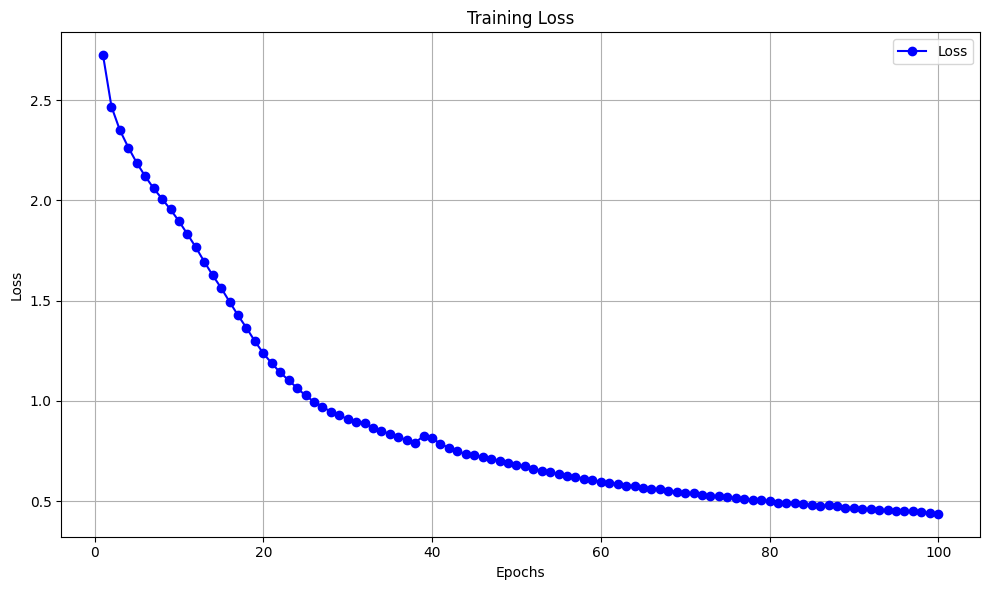

In [104]:
plot_training_history(history['loss_history'])

# Save model

In [175]:
# Save the trained model to an H5 file

model.save("gru4rec_model.keras")

# Test Load model

In [176]:
from tensorflow.keras.models import load_model



loaded_model = load_model(

    "gru4rec_model.keras",
    custom_objects = {
        'GRU4REC': GRU4REC,
    }

)

items size: 10676
genres size: 1200


In [177]:
weights = loaded_model.get_weights()

# Check if weights are non-zero
is_trained = any(np.any(w != 0) for w in weights)

if is_trained:
    print("The model appears to be trained (non-zero weights).")
else:
    print("The model is not trained (weights are all zero or uninitialized).")

The model appears to be trained (non-zero weights).


In [178]:
# sequence_length = loaded_model.layers[0].input_shape[1]  # Assuming the input shape is (batch_size, sequence_length, features)
# print(f"Model expects input sequences of length: {sequence_length}")

input_shape = loaded_model.input
print(f"Model expects input shape: {input_shape}")

for i, layer in enumerate(loaded_model.layers):
    print(f"Layer {i}: {layer.name}")
    print(f"Type: {type(layer)}")
    print(f"Config: {layer.get_config()}")
    print("---")

ValueError: The layer gru4rec_29 has never been called and thus has no defined input.

In [185]:

items_sequence = np.array([0, 0, 0, 0, 5, 37, 999, 165, 24, 37])
features_sequence = np.array([])
genres_sequence = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [1, 2, 3, 4, 5, 0, 0, 0, 0, 0],
                            [1, 2, 3, 4, 5, 0, 0, 0, 0, 0],
                            [1, 2, 3, 4, 5, 0, 0, 0, 0, 0],
                            [1, 2, 3, 4, 5, 0, 0, 0, 0, 0],
                            [1, 2, 3, 4, 5, 0, 0, 0, 0, 0],
                            [1, 2, 3, 4, 5, 0, 0, 0, 0, 0],
                           ]
                          )

# input_shape = loaded_model.input_shape
# print(input_shape)
target_sequence_length = loaded_model.input_shape[1]



padded_items_sequence = np.pad(items_sequence, (target_sequence_length - len(items_sequence), 0), mode='constant', constant_values=0)

# Pre-pad genres_sequence (assuming each genre sequence has 10 features)
padded_genres_sequence = np.pad(genres_sequence, ((0, 0), (target_sequence_length - genres_sequence.shape[1], 0)), mode='constant', constant_values=0)

# Check if features_sequence is provided; if not, we handle it accordingly.
# If it's empty or needs padding, you can decide how to handle it (e.g., padding with zeros or a specific method).
# Since the features_sequence array is empty in this example, we'll skip padding for it.
# Add batch dimension for batch size = 1
padded_items_sequence = np.expand_dims(padded_items_sequence, axis=0)  # Shape: (1, sequence_length)
padded_genres_sequence = np.expand_dims(padded_genres_sequence, axis=0)  # Shape: (1, sequence_length, num_features)

# features_sequence is empty in this case, but if it had values, we would similarly expand its dimensions

# Ensure features_sequence is also 2D with a batch size of 1
# If features_sequence is empty, you could represent it as an empty array of appropriate shape, e.g., (1, 0)
features_sequence = np.expand_dims(features_sequence, axis=0) if features_sequence.size > 0 else np.empty((1, 0))

# Print padded sequences to verify the shapes
print("Padded Items Sequence (Pre-padded):")
print(padded_items_sequence)
print("\nPadded Genres Sequence (Pre-padded):")
print(padded_genres_sequence)

Padded Items Sequence (Pre-padded):
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   5  37 999 165  24  37]]

Padded Genres Sequence (Pre-padded):
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


In [186]:


# Now the input is ready to be passed to the model
predicted_sequence = loaded_model(
    (padded_items_sequence, features_sequence, padded_genres_sequence), 
    training=False
)

# Output prediction
print(predicted_sequence)

InvalidArgumentError: Exception encountered when calling GRU4REC.call().

[1m{{function_node __wrapped__ConcatV2_N_2_device_/job:localhost/replica:0/task:0/device:GPU:0}} ConcatOp : Dimension 1 in both shapes must be equal: shape[0] = [1,118,1,32] vs. shape[1] = [1,10,1,32] [Op:ConcatV2] name: concat[0m

Arguments received by GRU4REC.call():
  • inputs=('tf.Tensor(shape=(1, 118), dtype=float32)', 'tf.Tensor(shape=(1, 0), dtype=float32)', 'tf.Tensor(shape=(1, 10, 118), dtype=float32)')
  • training=False